# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

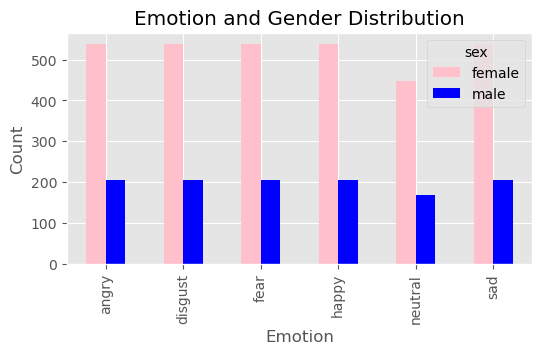

In [9]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

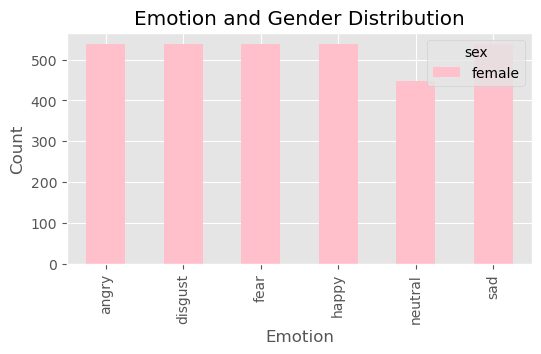

In [10]:
# I decided to go with a female specific model 
df = df[df['sex'] == 'female']
plot_distribution(df)

In [11]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,fear


In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

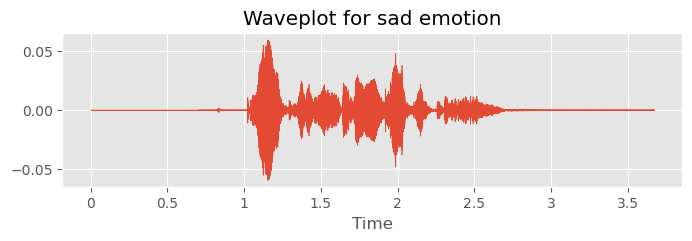

In [13]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [14]:
from pydub import AudioSegment, effects

In [15]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [16]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features: 

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [17]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [18]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [21]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [22]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
461/461 [==============================] - 20s 18ms/step - loss: 1.6603 - categorical_accuracy: 0.2652 - val_loss: 1.4891 - val_categorical_accuracy: 0.3523
Epoch 2/200
461/461 [==============================] - 8s 17ms/step - loss: 1.4417 - categorical_accuracy: 0.3755 - val_loss: 1.3842 - val_categorical_accuracy: 0.4205
Epoch 3/200
461/461 [==============================] - 8s 17ms/step - loss: 1.2929 - categorical_accuracy: 0.4428 - val_loss: 1.1959 - val_categorical_accuracy: 0.5189
Epoch 4/200
461/461 [==============================] - 8s 17ms/step - loss: 1.1487 - categorical_accuracy: 0.5326 - val_loss: 1.1405 - val_categorical_accuracy: 0.5455
Epoch 5/200
461/461 [==============================] - 8s 17ms/step - loss: 1.0365 - categorical_accuracy: 0.5930 - val_loss: 0.9917 - val_categorical_accuracy: 0.5947
Epoch 6/200
461/461 [==============================] - 8s 17ms/step - loss: 1.0091 - categorical_accuracy: 0.6302 - val_loss: 1.0309 - val_categorical_accuracy

# 6. Evaluate and conclude

Let's see how good are model is. 

In [24]:
from sklearn.metrics import confusion_matrix

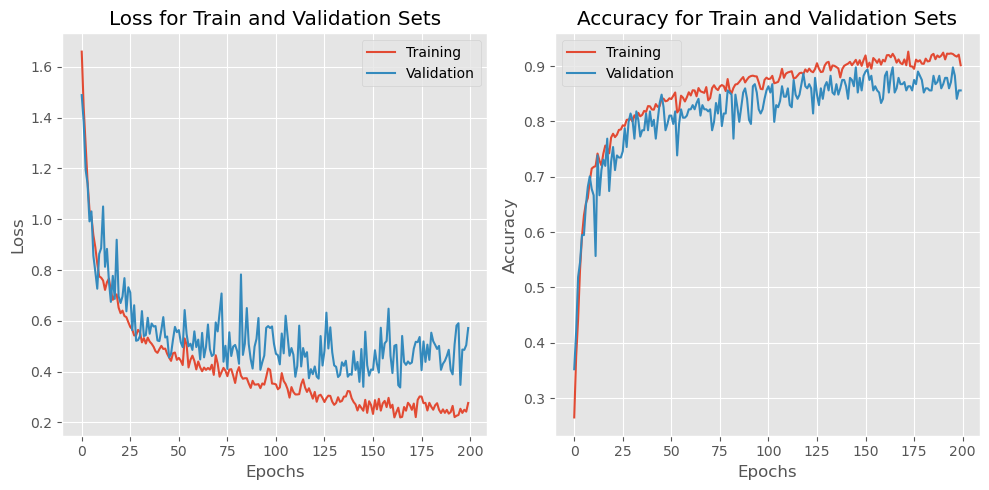

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 1s 18ms/step


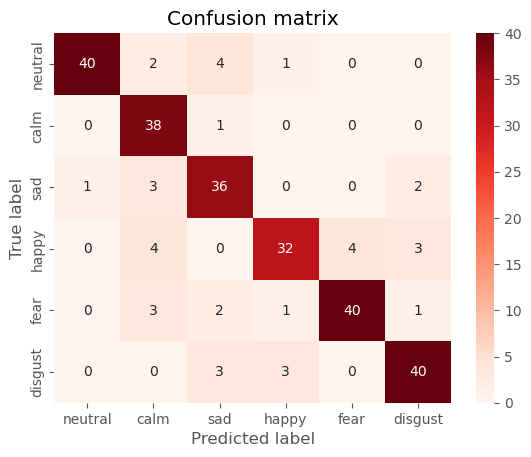

In [26]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [27]:
MODEL.save("model.h5")

import librosa
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

class EmotionRecognizer:
    def __init__(self, model_path='model.h5'):
        self.model_path = model_path
        self.model = None
        self.scaler = None
        self.required_time_steps = 352
        self.emotion_map = {
            0: 'neutral',
            1: 'happy',
            2: 'sad',
            3: 'angry',
            4: 'fear',
            5: 'disgust'
        }
        
    def load_model(self):
        """Load the trained model."""
        try:
            self.model = load_model(self.model_path)
            print("Model loaded successfully")
            return True
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False

    def extract_features(self, audio_path):
        """Extract and normalize audio features matching the original 15 features."""
        try:
            # Load audio file
            y, sr = librosa.load(audio_path, sr=22050, duration=3)
            
            # Set consistent parameters
            frame_length = 2048
            hop_length = 512
            
            # Extract only the original features
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
            rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
            
            # Print shapes for debugging
            print("\nFeature shapes before processing:")
            print(f"ZCR shape: {zcr.shape}")
            print(f"RMS shape: {rms.shape}")
            print(f"MFCCs shape: {mfccs.shape}")
            
            # Ensure all features have the same time steps
            min_time_steps = min(zcr.shape[1], rms.shape[1], mfccs.shape[1])
            
            # Trim all features to minimum length
            zcr = zcr[:, :min_time_steps]
            rms = rms[:, :min_time_steps]
            mfccs = mfccs[:, :min_time_steps]
            
            # Stack features (15 features total: 1 ZCR + 1 RMS + 13 MFCCs)
            features = np.vstack([zcr, rms, mfccs])
            
            # Handle time steps
            if features.shape[1] < self.required_time_steps:
                # Use repetition instead of zero padding
                repeat_times = self.required_time_steps // features.shape[1] + 1
                features = np.tile(features, (1, repeat_times))[:, :self.required_time_steps]
            elif features.shape[1] > self.required_time_steps:
                # Take center portion
                start_idx = (features.shape[1] - self.required_time_steps) // 2
                features = features[:, start_idx:start_idx + self.required_time_steps]
            
            # Transpose to (time_steps, features)
            features = features.T
            
            # Initialize scaler if needed
            if self.scaler is None:
                self.scaler = StandardScaler()
                features_normalized = self.scaler.fit_transform(features)
            else:
                features_normalized = self.scaler.transform(features)
            
            # Expand dimensions for model input
            features_final = np.expand_dims(features_normalized, axis=0)
            
            print(f"\nFinal feature shape: {features_final.shape}")
            return features_final
            
        except Exception as e:
            print(f"Error in feature extraction: {str(e)}")
            raise

    def predict_emotion(self, audio_path):
        """Predict emotion with detailed probability output."""
        try:
            # Load model if not already loaded
            if self.model is None:
                if not self.load_model():
                    return None, None, None
            
            # Extract features
            X_input = self.extract_features(audio_path)
            
            # Get predictions
            predictions = self.model.predict(X_input, verbose=0)
            
            # Get probabilities for all emotions
            emotion_probabilities = {
                self.emotion_map[i]: float(prob) 
                for i, prob in enumerate(predictions[0])
            }
            
            # Get predicted emotion and confidence
            predicted_class = np.argmax(predictions[0])
            predicted_emotion = self.emotion_map[predicted_class]
            confidence = predictions[0][predicted_class]
            
            return predicted_emotion, confidence, emotion_probabilities
            
        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            return None, None, None

    def process_directory(self, directory_path):
        """Process all audio files in a directory."""
        results = []
        
        for file in os.listdir(directory_path):
            if file.endswith(('.wav', '.mp3')):
                print(f"\nProcessing: {file}")
                audio_path = os.path.join(directory_path, file)
                emotion, confidence, probs = self.predict_emotion(audio_path)
                
                if emotion:
                    results.append({
                        'file': file,
                        'emotion': emotion,
                        'confidence': confidence,
                        'probabilities': probs
                    })
                
        return results

def main():
    # Initialize the emotion recognizer
    recognizer = EmotionRecognizer('model.h5')
    
    # Test single file
    audio_path = "/kaggle/input/urdu-emotion-dataset/Sad/SM23_F1_S07.wav"
    
    try:
        emotion, confidence, probabilities = recognizer.predict_emotion(audio_path)
        
        if emotion:
            print("\nPrediction Results:")
            print(f"Predicted Emotion: {emotion}")
            print(f"Confidence: {confidence:.2%}")
            print("\nProbabilities for all emotions:")
            for emotion_name, prob in probabilities.items():
                print(f"{emotion_name}: {prob:.2%}")
        else:
            print("Failed to predict emotion.")
            
    except Exception as e:
        print(f"Error in main: {str(e)}")

if __name__ == "__main__":
    main()

Model loaded successfully

Feature shapes before processing:
ZCR shape: (1, 87)
RMS shape: (1, 87)
MFCCs shape: (13, 87)

Final feature shape: (1, 352, 15)

Prediction Results:
Predicted Emotion: fear
Confidence: 100.00%

Probabilities for all emotions:
neutral: 0.00%
happy: 0.00%
sad: 0.00%
angry: 0.00%
fear: 100.00%
disgust: 0.00%


In [28]:
print("HI")

HI


**Conclusion**

In summary, our model achieved 90% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process. 